# Installations

In [ ]:
!sudo apt-get install git-lfs
!git lfs install

!git clone https://github.com/yandex/geo-reviews-dataset-2023.git

%cd geo-reviews-dataset-2023
!git lfs pull
!ls -lh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Git LFS initialized.
Cloning into 'geo-reviews-dataset-2023'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 167.74 KiB | 6.99 MiB/s, done.
/content/geo-reviews-dataset-2023
total 362M
-rw-r--r-- 1 root root  225 Aug 27 05:50 AUTHORS.md
-rw-r--r-- 1 root root 1.9K Aug 27 05:50 CONTRIBUTING.md
-rw-r--r-- 1 root root 362M Aug 27 05:50 geo-reviews-dataset-2023.tskv
-rw-r--r-- 1 root root 1.1K Aug 27 05:50 LICENSE.md
drwxr-xr-x 2 root root 4.0K Aug 27 05:50 media
-rw-r--r-- 1 root root 2.9K Aug 27 05:50 README.md


In [ ]:
! pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


# Libs

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

#Read data

In [ ]:
df = pd.read_csv('/content/geo-reviews-dataset-2023/geo-reviews-dataset-2023.tskv', sep='\t', header=None)

# Эта штука нужна, потому что в датасете есть сдвинутые строки с отсутствующим name_ru
shifted_rows = df[df[4].isna()]
df.loc[shifted_rows.index, 4] = df.loc[shifted_rows.index, 3]  # Move rubrics to text
df.loc[shifted_rows.index, 3] = df.loc[shifted_rows.index, 2]  # Move rating to rubrics
df.loc[shifted_rows.index, 2] = df.loc[shifted_rows.index, 1]  # Move name_ru to rating
df.loc[shifted_rows.index, 1] = 'name_ru='  # Set name_ru to name_ru=

expected_keys = ['address=', 'name_ru=', 'rating=', 'rubrics=', 'text=']

for i, key in enumerate(expected_keys):
    df[i] = df[i].str.replace(key, '', regex=False)

df.columns = ['address', 'name_ru', 'rating', 'rubrics', 'text']

In [ ]:
df

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...
...,...,...,...,...,...
499995,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4.,Железнодорожная станция,"Охрана кривая но добрая, двери не закрываются ..."
499996,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4.,Железнодорожная станция,По сравнению со многими современными платформа...
499997,"Новосибирск, Коммунистическая улица, 48А",,5.,"Бар, паб","Приятная атмосфера, прекрасное вино, волшебная..."
499998,"Астраханская область, Харабалинский район",Сарай-Бату,5.,Достопримечательность,Был с семьёй 13.06.23 Отличное место. Рекоменд...


In [ ]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

In [ ]:
df.rating.describe()

,rating
count,500000.00000
mean,4.48160
std,1.14625
min,0.00000
25%,5.00000
50%,5.00000
75%,5.00000
max,5.00000


# Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/test.tskv', sep='\t', header=None)

expected_keys = ['address=', 'name_ru=', 'rubrics=', 'text=']

for i, key in enumerate(expected_keys):
    test[i] = test[i].str.replace(key, '', regex=False)

test.columns = ['address', 'name_ru', 'rubrics', 'text']

In [ ]:
test

,address,name_ru,rubrics,text
0,"Московская обл., Электроугли, ул. Школьная, вб...",Школьная,Жилой комплекс,Как то он выгледит по другому и не так красиво...
1,"Москва, Ленинский проспект, 34/1",Банк ВТБ,Банк,Не решили вопрос \nВ приложении втб прислали с...
2,"Москва, улица Плеханова, 17, стр. 6",Перово Плаза,Гостиница,"Ужасное место,при заезде не могли никак засели..."
3,"Москва, Каширское шоссе, 57, корп. 4",Пятёрочка,Супермаркет,Всегда нереально медленные кассиры
4,"Москва, Головинское шоссе, 5, корп. 1",О'кей,Продуктовый гипермаркет;Гипермаркет,Самое ужасное мясо на развес. Всегда продают т...
...,...,...,...,...
19995,"Приморский край, Владивосток, полуостров Шкота",Спортплощадка,Спортплощадка,Спорт плошадка классная есть несколько тренаже...
19996,"Томск, Московский тракт, 43",Белая соборная мечеть,Мечеть,"Прекрасное место, где можно отдохнуть душой."
19997,"Московская область, Раменский городской округ,...",Американ клаб,"Авторазбор;Автосервис, автотехцентр","Персонал очень отзывчивый, профильный сервис д..."
19998,"Москва, улица Перерва, 32",АвтоЛидер,Магазин автозапчастей и автотоваров;Страховани...,Всё отлично


# df cleaning

In [ ]:
df.shape

(500000, 5)

In [ ]:
df_filtered_address = df[df['address'].isin(test['address'])]

df_filtered_name = df[df['name_ru'].isin(test['name_ru'])]
df_filtered_text = df[df['text'].isin(test['text'])]
df_filtered = pd.concat([df_filtered_address, df_filtered_name, df_filtered_text]).drop_duplicates()
df_filtered = df_filtered.reset_index(drop=True)

# df classes balancing

In [ ]:
df_filtered = df_filtered[df_filtered['rating'] != 0]
df_filtered.rating = df_filtered.rating.astype(str)
df_filtered["label"] = df_filtered.rating.apply(lambda x: int(x[0]) - 1)
df_filtered = df_filtered.drop(columns=['rating'])

In [ ]:
df_filtered

,address,name_ru,rubrics,text,label
0,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...",4
1,"Кемерово, проспект Ленина, 59А",Прованс,Кондитерская,Вкусное место в центре города. Разнообразное ...,4
2,"Ямало-Ненецкий автономный округ, Новый Уренгой...",Dream Hostel,Хостел,"Отлично!\nОсобенно, ""трешка""-трёхместный номер...",4
3,"Ямало-Ненецкий автономный округ, Новый Уренгой...",Dream Hostel,Хостел,"Чистота, обслуживание на высоком уровне, столо...",4
4,"Московская область, Богородский городской окру...",La Vie EN Roses,Магазин цветов;Магазин подарков и сувениров;То...,Спасибо за красивый качественный букетик цвето...,4
...,...,...,...,...,...
206545,"Ставропольский край, Пятигорск, проспект Калин...",Гиро,Кафе;Быстрое питание;Кофейня,Все очень вкусно,4
206546,"Удмуртская Республика, Ижевск, улица Максима Г...",Мамины блины,Быстрое питание;Кафе,Очень вкусно,4
206547,"Тула, Ложевая улица, 130Д",Настоящая пекарня,Пекарня,Вкусно,4
206548,"Ярославская область, Рыбинск, Центральный микр...",Луиджи,Кафе,Мало места,3


In [ ]:
df_filtered['label'].value_counts()

,count
label,
4,153465
3,20499
0,15901
2,10797
1,5793


In [ ]:
samples_per_class = 5000

# Initialize a list to store the sampled DataFrames
sampled_dfs = []

for label in df_filtered['label'].unique():
    sampled_df = df_filtered[df_filtered['label'] == label].sample(n=samples_per_class, random_state=42)
    sampled_dfs.append(sampled_df)

# Combine all sampled DataFrames into one balanced DataFrame
balanced_df = pd.concat(sampled_dfs).reset_index(drop=True)

# Check the distribution to confirm the balance
print(balanced_df['label'].value_counts())

label
4    5000
0    5000
2    5000
3    5000
1    5000
Name: count, dtype: int64


In [ ]:
balanced_df = balanced_df[['text', 'label']]

In [ ]:
import pandas as pd

# Set the number of rows per class for the two datasets
rows_in_dataset_1 = 4000
rows_in_dataset_2 = 1000

# Initialize lists to hold the two datasets
dataset_1 = []
dataset_2 = []

# Iterate over each unique label (class)
for label in balanced_df['label'].unique():
    # Shuffle and split the DataFrame for the current class
    class_df = balanced_df[balanced_df['label'] == label].sample(frac=1, random_state=42)

    # First dataset with 3000 rows per class
    dataset_1.append(class_df.iloc[:rows_in_dataset_1])

    # Second dataset with 1000 rows per class
    dataset_2.append(class_df.iloc[rows_in_dataset_1:rows_in_dataset_1 + rows_in_dataset_2])

# Combine the splits to form the final datasets
dataset_1 = pd.concat(dataset_1)
dataset_2 = pd.concat(dataset_2)

# Check the distribution of each dataset to ensure balance
print("Dataset 1 distribution:")
print(dataset_1['label'].value_counts())

print("\nDataset 2 distribution:")
print(dataset_2['label'].value_counts())

Dataset 1 distribution:
label
4    4000
0    4000
2    4000
3    4000
1    4000
Name: count, dtype: int64

Dataset 2 distribution:
label
4    1000
0    1000
2    1000
3    1000
1    1000
Name: count, dtype: int64


In [ ]:
dataset_1.to_csv('dataset_1.csv', index=False)
dataset_2.to_csv('dataset_2.csv', index=False)

In [ ]:
dataset_1 = pd.read_csv('/content/geo-reviews-dataset-2023/dataset_1.csv')
dataset_2 = pd.read_csv('/content/geo-reviews-dataset-2023/dataset_2.csv')

# Define a function to sample a fraction of rows for each class
def filter_by_fraction(df, fraction):
    filtered_dfs = []
    for label in df['label'].unique():
        class_df = df[df['label'] == label]
        sample_size = int(len(class_df) * fraction)
        sampled_df = class_df.sample(n=sample_size, random_state=42)
        filtered_dfs.append(sampled_df)
    return pd.concat(filtered_dfs).reset_index(drop=True)

# Apply filtering to dataset_1 (0.5 fraction per label)
dataset_1= filter_by_fraction(dataset_1, 0.25)

# Apply filtering to dataset_2 (0.1 fraction per label)
dataset_2= filter_by_fraction(dataset_2, 0.1)

In [ ]:
dataset_1.to_csv('dataset_1.csv', index=False)
dataset_2.to_csv('dataset_2.csv', index=False)

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [ ]:
dataset_1 = pd.read_csv('/content/geo-reviews-dataset-2023/dataset_1.csv')
dataset_2 = pd.read_csv('/content/geo-reviews-dataset-2023/dataset_2.csv')

In [ ]:
train_df_mini, val_df_mini = dataset_1, dataset_2

In [ ]:
train_dataset = Dataset.from_pandas(train_df_mini)
val_dataset = Dataset.from_pandas(val_df_mini)

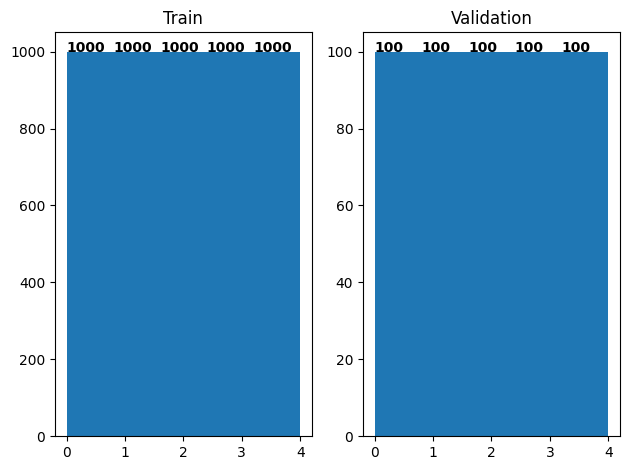

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Validation");
train_distributions = axs[0].hist(train_dataset["label"], bins=5)
val_distributions = axs[1].hist(val_dataset["label"], bins=5)

for distributions, ax in zip([train_distributions, val_distributions], axs):
    for j in range(5):
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

# Baseline

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
EPOCHS = 10

id2label = {k:k for k in range(5)}
label2id = {k:k for k in range(5)}

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ds = {"train": train_dataset, "validation": val_dataset}

def preprocess_function(examples):
    label = examples["label"]
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    examples["label"] = label
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "label"])


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-13-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
from transformers import TrainingArguments

BATCH_SIZE = 40

training_args = TrainingArguments(
    output_dir="../models/camembert-fine-tuned-regression",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import gc
gc.collect()

5068

In [ ]:
import numpy as np

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.529102,0.304000
2,No log,1.506654,0.328000
3,No log,1.537569,0.316000
4,1.464400,1.514288,0.344000
5,1.464400,1.508259,0.334000
6,1.464400,1.520878,0.356000
7,1.464400,1.524814,0.360000
8,1.379600,1.528967,0.350000
9,1.379600,1.526081,0.360000
10,1.379600,1.534596,0.340000


TrainOutput(global_step=1250, training_loss=1.4028273681640624, metrics={'train_runtime': 2189.8776, 'train_samples_per_second': 22.832, 'train_steps_per_second': 0.571, 'total_flos': 6577953561600000.0, 'train_loss': 1.4028273681640624, 'epoch': 10.0})

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SOTA2024/model.pth')

#ADJ

In [ ]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 88.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=d9c81b7a02f489819a1963450acf1b93a33b2349f543f38c9b165ceaaef972ce
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
from datasets import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
nltk.download('punkt')

# Загрузка датасетов
dataset_1 = pd.read_csv('/content/geo-reviews-dataset-2023/dataset_1.csv')
dataset_2 = pd.read_csv('/content/geo-reviews-dataset-2023/dataset_2.csv')

# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

# Функция для выделения прилагательных
def extract_adjectives(text):
    words = word_tokenize(text)
    adjectives = []
    for word in words:
        parsed_word = morph.parse(word)[0]
        if 'ADJF' in parsed_word.tag:  # Проверка на прилагательное
            adjectives.append(parsed_word.normal_form)  # Приведение к нормальной форме
    return " ".join(adjectives)

# Применение функции к датасетам для выделения прилагательных
dataset_1['adjectives'] = dataset_1['text'].apply(extract_adjectives)
dataset_2['adjectives'] = dataset_2['text'].apply(extract_adjectives)

# Преобразование данных в Dataset объект
train_df_mini, val_df_mini = dataset_1, dataset_2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-3ecf43f3fd97>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u

In [ ]:
# Конвертация pandas DataFrame в Dataset
train_dataset = Dataset.from_pandas(train_df_mini)
val_dataset = Dataset.from_pandas(val_df_mini)

# Инициализация токенизатора и модели
BASE_MODEL = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=5)

model.load_state_dict(torch.load('/content/drive/MyDrive/SOTA2024/model.pth'))

model.eval()

def preprocess_function(examples):
    texts = examples["adjectives"]
    labels = examples["label"]
    tokens = tokenizer(texts, truncation=True, padding="max_length", max_length=256)
    tokens["label"] = labels
    return tokens

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-39-ef5f4383c6aa>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly al

In [ ]:
train_dataset = train_dataset.map(preprocess_function, remove_columns=["text", "adjectives", "label"])
val_dataset = val_dataset.map(preprocess_function, remove_columns=["text", "adjectives", "label"])

# Настройки тренировки
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.01,
)

# Инициализация Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.557378
2,No log,1.556633
3,No log,1.587659
4,1.564700,1.578780
5,1.564700,1.571470


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SOTA2024/model_2.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [ ]:
tqdm.pandas()
df_test['rating'] = df_test.progress_apply(predict_rating, axis=1)

100%|██████████| 20000/20000 [09:24<00:00, 35.41it/s]


In [ ]:
preds = df_test.copy()

In [ ]:
preds['rating'] = preds['rating'].apply(lambda x: str(f'{x + 1}.'))

In [ ]:
preds['rating'] = preds['rating'].str.replace('[', '', regex=False)  # Удаление открывающей скобки
preds['rating'] = preds['rating'].str.replace(']', '', regex=False)  # Удаление закрывающей скобки
preds['rating'] = preds['rating'].str.replace('.', '', regex=False)  # Удаление точки

# Теперь преобразуем строку в int
preds['rating'] = preds['rating'].astype(int)

In [ ]:
preds['rating'] = preds['rating'].apply(lambda x: str(f'{x}.'))

In [ ]:
# Функция для преобразования строки DataFrame в формат TSKV
def row_to_tskv(row):
    #tskv_str = "tskv\t"  # Начало строки с "tskv"
    tskv_str = "\t".join([f"{col}={row[col]}" for col in row.index])
    return tskv_str

# Применяем функцию ко всем строкам DataFrame и сохраняем в файл
with open('/content/E_f.tskv', 'w') as f:
    for _, row in preds.iterrows():
        f.write(row_to_tskv(row) + "\n")

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.571289
2,No log,1.570368
3,No log,1.578345
4,1.526400,1.573683
5,1.526400,1.597540
6,1.526400,1.591792
7,1.498600,1.603329
8,1.498600,1.604990
9,1.498600,1.607447
10,1.469000,1.608030


TrainOutput(global_step=1570, training_loss=1.4966632964504751, metrics={'train_runtime': 2144.7006, 'train_samples_per_second': 23.313, 'train_steps_per_second': 0.732, 'total_flos': 6577953561600000.0, 'train_loss': 1.4966632964504751, 'epoch': 10.0})

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SOTA2024/model3.pth')

#Load

In [ ]:
BASE_MODEL = "camembert-base"
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=5)

# Загрузка сохранённых параметров модели
model.load_state_dict(torch.load('/content/drive/MyDrive/SOTA2024/model3.pth'))

# Перевод модели в режим оценки (evaluation mode)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-623adaf36a47>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

# Preds

In [ ]:
def parse_tskv_line(line):
    # Разделяем строку по табуляции и создаём словарь из пар ключ-значение.
    return dict(item.split('=', 1) for item in line.strip().split('\t'))

with open('/content/drive/MyDrive/test.tskv', 'r') as file:
    data = [parse_tskv_line(line) for line in file]

df_test = pd.DataFrame(data)
df_test.head()

,address,name_ru,rubrics,text
0,"Московская обл., Электроугли, ул. Школьная, вб...",Школьная,Жилой комплекс,Как то он выгледит по другому и не так красиво...
1,"Москва, Ленинский проспект, 34/1",Банк ВТБ,Банк,Не решили вопрос \nВ приложении втб прислали с...
2,"Москва, улица Плеханова, 17, стр. 6",Перово Плаза,Гостиница,"Ужасное место,при заезде не могли никак засели..."
3,"Москва, Каширское шоссе, 57, корп. 4",Пятёрочка,Супермаркет,Всегда нереально медленные кассиры
4,"Москва, Головинское шоссе, 5, корп. 1",О'кей,Продуктовый гипермаркет;Гипермаркет,Самое ужасное мясо на развес. Всегда продают т...


In [ ]:
from tqdm import tqdm
import torch

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import pymorphy2

# Ensure NLTK resources are downloaded
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

# Функция для выделения прилагательных
def extract_adjectives(text):
    words = word_tokenize(text)
    adjectives = []
    for word in words:
        parsed_word = morph.parse(word)[0]
        if 'ADJF' in parsed_word.tag:  # Проверка на прилагательное
            adjectives.append(parsed_word.normal_form)  # Приведение к нормальной форме
    return " ".join(adjectives)

def predict_rating(row):
    # Извлечение прилагательных из текста
    adjectives = extract_adjectives(row['text'])

    # Токенизация извлечённых прилагательных
    encoded = tokenizer(adjectives, truncation=True, padding="max_length", max_length=256, return_tensors="pt")

    # Перемещение токенов на GPU, если доступно
    encoded = {k: v.to("cuda") for k, v in encoded.items()}

    # Перемещение модели на GPU, если доступно
    model.to("cuda")

    # Прогнозирование с помощью модели
    with torch.no_grad():
        logits = model(**encoded).logits

    # Получение предсказанных классов
    predicted_class = torch.argmax(logits, axis=1).detach().cpu().numpy()

    return predicted_class

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [ ]:
tqdm.pandas()
df_test['rating'] = df_test.progress_apply(predict_rating, axis=1)

100%|██████████| 20000/20000 [08:30<00:00, 39.19it/s]


In [ ]:
def predict_rating(row):

    encoded = tokenizer(row['text'], truncation=True, padding="max_length", max_length=256, return_tensors="pt").to("cuda")
    logits = model(**encoded).logits
    return torch.argmax(logits, axis=1).detach().cpu().numpy()

tqdm.pandas()
# Предсказываем классы
df_test['rating'] = df_test.progress_apply(predict_rating, axis=1)
# df_test.head()

100%|██████████| 20000/20000 [06:15<00:00, 53.32it/s]


In [ ]:
df_test['text'].values

array(['Как то он выгледит по другому и не так красиво как на картинке...Обман',
       'Не решили вопрос \\nВ приложении втб прислали сообщение- обратиться в любое отделение банка для решения вопроса мат капитала. По факту обращения в это отделение сказали, что этим не занимаются и послали самостоятельно решать вопрос на горячую линию.',
       'Ужасное место,при заезде не могли никак заселить.Выдадут карту от номера то в гряздный номер,с взлохмаченой кроватью и грязными простынями,после притензии вообще выдали ключ от номера где уже живут люди,заходишь а там человек спит-ну такое себе удовольствие.В коридорах вонь,пока поднимались встретили тараканчика. Наши нервы не выдержали и естественно мы развернулись,попросили вернуть деньги за зачисление и бегом от туда.Не советую ни в коем случае.',
       ...,
       'Персонал очень отзывчивый, профильный сервис для американских авто, но берут в работу и другие марки, остался доволен шиномонтажными работами',
       'Всё отлично',
       'Сн

In [ ]:
preds = df_test.copy()

In [ ]:
preds['rating'] = preds['rating'].apply(lambda x: str(f'{x + 1}.'))

In [ ]:
preds['rating'] = preds['rating'].str.replace('[', '', regex=False)  # Удаление открывающей скобки
preds['rating'] = preds['rating'].str.replace(']', '', regex=False)  # Удаление закрывающей скобки
preds['rating'] = preds['rating'].str.replace('.', '', regex=False)  # Удаление точки

# Теперь преобразуем строку в int
preds['rating'] = preds['rating'].astype(int)

In [ ]:
preds['rating'] = preds['rating'].apply(lambda x: str(f'{x}.'))

In [ ]:
preds

,address,name_ru,rubrics,text,rating
0,"Московская обл., Электроугли, ул. Школьная, вб...",Школьная,Жилой комплекс,Как то он выгледит по другому и не так красиво...,3.
1,"Москва, Ленинский проспект, 34/1",Банк ВТБ,Банк,Не решили вопрос \nВ приложении втб прислали с...,1.
2,"Москва, улица Плеханова, 17, стр. 6",Перово Плаза,Гостиница,"Ужасное место,при заезде не могли никак засели...",4.
3,"Москва, Каширское шоссе, 57, корп. 4",Пятёрочка,Супермаркет,Всегда нереально медленные кассиры,1.
4,"Москва, Головинское шоссе, 5, корп. 1",О'кей,Продуктовый гипермаркет;Гипермаркет,Самое ужасное мясо на развес. Всегда продают т...,5.
...,...,...,...,...,...
19995,"Приморский край, Владивосток, полуостров Шкота",Спортплощадка,Спортплощадка,Спорт плошадка классная есть несколько тренаже...,1.
19996,"Томск, Московский тракт, 43",Белая соборная мечеть,Мечеть,"Прекрасное место, где можно отдохнуть душой.",1.
19997,"Московская область, Раменский городской округ,...",Американ клаб,"Авторазбор;Автосервис, автотехцентр","Персонал очень отзывчивый, профильный сервис д...",5.
19998,"Москва, улица Перерва, 32",АвтоЛидер,Магазин автозапчастей и автотоваров;Страховани...,Всё отлично,4.


In [ ]:
# Функция для преобразования строки DataFrame в формат TSKV
def row_to_tskv(row):
    #tskv_str = "tskv\t"  # Начало строки с "tskv"
    tskv_str = "\t".join([f"{col}={row[col]}" for col in row.index])
    return tskv_str

# Применяем функцию ко всем строкам DataFrame и сохраняем в файл
with open('E_adj.tskv', 'w') as f:
    for _, row in preds.iterrows():
        f.write(row_to_tskv(row) + "\n")

In [ ]:
# df_test['rating'] = '5.'

In [ ]:
with open('test_with_rating.tskv', 'w') as file:
    for index, row in df_test.iterrows():
        line = ''
        for column in df_test.columns:
            line += f'{column}={row[column]}\t'
        print(line.strip(), end='\n', file=file)

with open('test_with_rating.tskv', 'r') as file:
    data = [parse_tskv_line(line) for line in file]

df_test2 = pd.DataFrame(data)
df_test2.head()

,address,name_ru,rubrics,text,rating
0,"Московская обл., Электроугли, ул. Школьная, вб...",Школьная,Жилой комплекс,Как то он выгледит по другому и не так красиво...,5.
1,"Москва, Ленинский проспект, 34/1",Банк ВТБ,Банк,Не решили вопрос \nВ приложении втб прислали с...,5.
2,"Москва, улица Плеханова, 17, стр. 6",Перово Плаза,Гостиница,"Ужасное место,при заезде не могли никак засели...",5.
3,"Москва, Каширское шоссе, 57, корп. 4",Пятёрочка,Супермаркет,Всегда нереально медленные кассиры,5.
4,"Москва, Головинское шоссе, 5, корп. 1",О'кей,Продуктовый гипермаркет;Гипермаркет,Самое ужасное мясо на развес. Всегда продают т...,5.


In [ ]:
df_test[df_test['text'].str.contains('оценка')].shape

(49, 4)

In [ ]:
df_test[df_test['text'].str.contains('оценка')]['text'].values

array(['Сразу отмечу, что до еды дело не дошло, в заведении было жарко и душно, есть и потеть еще больше не хотелось, поэтому мы ушли. \\n\\nМоя оценка за сервис и отзыв про него: \\n\\n- На входе встретили фразой: «Лучше снять верхнюю одежду, чтобы другим гостям было комфортнее». Мы только зашли, а нам уже не рады. «Вам будет удобнее без верхней одежды» - смысл тот же, посыл другой. Задача персонала думать о комфорте гостей! Также отмечу, что на дворе теплый сентябрь, пиджак на плечах не помешал бы другим.\\n- Лица у персонала в лучшем случае безучастные, но в основном недовольные, аж неловко беспокоить.\\n- Поводом к посещению был день рождения, поэтому хотелось сесть в уютном месте (не посреди зала). При брони уточнили, что конкретный стол не бронируют и сажают по факту. В итоге пришли, половина столов свободны, сажают ровно туда, куда не хотелось. \\n- Стол на 4 персоны, нас 3 и стула тоже 3. Это выглядит некрасиво (лысо) и сумку пришлось ставить на пол.\\n- На выходе спросили, поч

In [ ]:
df_test['rating'] = df_test['rating'].str.replace('[', '', regex=False)  # Удаление открывающей скобки
df_test['rating'] = df_test['rating'].str.replace(']', '', regex=False)  # Удаление закрывающей скобки
df_test['rating'] = df_test['rating'].str.replace('.', '', regex=False)  # Удаление точки

# Теперь преобразуем строку в int
df_test['rating'] = df_test['rating'].astype(int)

In [ ]:
df_test

,address,name_ru,rubrics,text,rating
0,"Московская обл., Электроугли, ул. Школьная, вб...",Школьная,Жилой комплекс,Как то он выгледит по другому и не так красиво...,1
1,"Москва, Ленинский проспект, 34/1",Банк ВТБ,Банк,Не решили вопрос \nВ приложении втб прислали с...,2
2,"Москва, улица Плеханова, 17, стр. 6",Перово Плаза,Гостиница,"Ужасное место,при заезде не могли никак засели...",0
3,"Москва, Каширское шоссе, 57, корп. 4",Пятёрочка,Супермаркет,Всегда нереально медленные кассиры,4
4,"Москва, Головинское шоссе, 5, корп. 1",О'кей,Продуктовый гипермаркет;Гипермаркет,Самое ужасное мясо на развес. Всегда продают т...,1
...,...,...,...,...,...
19995,"Приморский край, Владивосток, полуостров Шкота",Спортплощадка,Спортплощадка,Спорт плошадка классная есть несколько тренаже...,4
19996,"Томск, Московский тракт, 43",Белая соборная мечеть,Мечеть,"Прекрасное место, где можно отдохнуть душой.",4
19997,"Московская область, Раменский городской округ,...",Американ клаб,"Авторазбор;Автосервис, автотехцентр","Персонал очень отзывчивый, профильный сервис д...",4
19998,"Москва, улица Перерва, 32",АвтоЛидер,Магазин автозапчастей и автотоваров;Страховани...,Всё отлично,4


In [ ]:
df_test['rating'] = df_test['rating'].apply(lambda x: int(x) + 1)

In [ ]:
df_test.rating.value_counts()

,count
rating,
5,10696
1,3868
4,2647
3,1417
2,1372


In [ ]:
# Функция для преобразования строки DataFrame в формат TSKV
def row_to_tskv(row):
    #tskv_str = "tskv\t"  # Начало строки с "tskv"
    tskv_str = "\t".join([f"{col}={row[col]}" for col in row.index])
    return tskv_str

# Применяем функцию ко всем строкам DataFrame и сохраняем в файл
with open('E3.tskv', 'w') as f:
    for _, row in df_test.iterrows():
        f.write(row_to_tskv(row) + "\n")

In [ ]:
predsdata = pd.read_csv('/content/geo-reviews-dataset-2023/E3.tskv', sep='\t', header=None)

In [ ]:
predsdata

,0,1,2,3,4
0,"address=Московская обл., Электроугли, ул. Школ...",name_ru=Школьная,rubrics=Жилой комплекс,text=Как то он выгледит по другому и не так кр...,rating=2
1,"address=Москва, Ленинский проспект, 34/1",name_ru=Банк ВТБ,rubrics=Банк,text=Не решили вопрос \nВ приложении втб присл...,rating=3
2,"address=Москва, улица Плеханова, 17, стр. 6",name_ru=Перово Плаза,rubrics=Гостиница,"text=Ужасное место,при заезде не могли никак з...",rating=1
3,"address=Москва, Каширское шоссе, 57, корп. 4",name_ru=Пятёрочка,rubrics=Супермаркет,text=Всегда нереально медленные кассиры,rating=5
4,"address=Москва, Головинское шоссе, 5, корп. 1",name_ru=О'кей,rubrics=Продуктовый гипермаркет;Гипермаркет,text=Самое ужасное мясо на развес. Всегда прод...,rating=2
...,...,...,...,...,...
19995,"address=Приморский край, Владивосток, полуостр...",name_ru=Спортплощадка,rubrics=Спортплощадка,text=Спорт плошадка классная есть несколько тр...,rating=5
19996,"address=Томск, Московский тракт, 43",name_ru=Белая соборная мечеть,rubrics=Мечеть,"text=Прекрасное место, где можно отдохнуть душой.",rating=5
19997,"address=Московская область, Раменский городско...",name_ru=Американ клаб,"rubrics=Авторазбор;Автосервис, автотехцентр","text=Персонал очень отзывчивый, профильный сер...",rating=5
19998,"address=Москва, улица Перерва, 32",name_ru=АвтоЛидер,rubrics=Магазин автозапчастей и автотоваров;Ст...,text=Всё отлично,rating=5


In [ ]:
predsdata.value_counts()

,,,,,count
0,1,2,3,4,
"address=посёлок городского типа Сириус, Олимпийский проспект, 7",name_ru=Дворец спорта Большой,rubrics=Спортивный комплекс,text=Вот уже десять как Большой дворец спорта принимает гостей. Ледовый дворец спорта как правило используется под хоккейные матчи местного клуба Сочи. Атмосфера всегда запоминающаяся. Дворец сделан таким образом что можно вкруговую обойти весь ледовый дворец. Имеется три магазина атрибуции ХК Сочи. Стадион большой и вместительный. Кто бывает в Сочи обязательно должен посетить «Большой»,rating=1,1
"address=посёлок городского типа Сириус, Парусная улица, 11",name_ru=БандитоБар,"rubrics=Бар, паб;Кафе;Ресторан",text=Очень интересная обстановка. Быстрое обслуживание. Вкусная закуска,rating=5,1
"address=посёлок городского типа Сириус, Парусная улица, 13",name_ru=Gelato amato,rubrics=Мороженое,text=Тут очень вкусное мороженое! Я ставлю 149/10.Там мне больше понравились сливочное и chocoладное мороженое. (так написал потому-что захотел ;) ),rating=5,1
"address=посёлок городского типа Сириус, Парусная улица, 21","name_ru=Альфа Сириус, Заповедный квартал",rubrics=Гостиница,"text=Проживали 2 недели с 1 июля в корпусе Е апартаменты с одной спальней. Ранее бывали неоднократно с 2014 года и в апартаментах и в отеле Имеретинский. Сейчас это Сириус. Конечно отель уже прямо подуставший. Но. Вопреки прочитанным отзывам перед поездкой, смело могу сказать,что многие отзывы- неправда. В плане уборки ругали отель-нам же или повезло или отзывы заказные. Убирали раз в 3-4 дня. Меняли постель также!!! По запросу сразу же предоставили бесплатно еще один комплект постельного белья. Мусор приходили спрашивали выносить - каждый день! Возникла проблема с кондиционером-сделали заявку вечером уже в 9 часу. Сначала сразу же пришла горничная. Утром в 9:30 у номера уже стоял мастер по ремонту. После того кау мы пришли с пляжа - все четко работало! В плане клиентоориентированности вопросов вообще не было и браво всем работникам! Но! Повторюсь. Номера конечно подуставшие. Ремонт не помешал бы. В апартаментах набор посуды,чашки,тарелки,ложки/вилки/ножи,терка(!),нож,открывашка. Все IKEA. Сковородка,ковшик,2 кастрюли. Холодильник громыхает конечно) Бассейн на территории Морского квартала отличный! Детские были закрыты. Вот площадки подкачали в Морском квартале. Ходили в другие кварталы. Но в общем и целом,мы не обращали внисание на некие недочеты! Все прошло гладко!",rating=1,1
"address=посёлок городского типа Сириус, Парусная улица, 9",name_ru=Traveler's Coffee,rubrics=Кофейня,"text=Отвратительное обслуживание. Трижды отказались принять заказ. Причем один раз на самой кассе, отправили ожидать за столик, когда официант сам подойдет. Официант нас игнорировал, когда официант приносил заказ за другой стол мы попросили, в очередной раз, принять заказ он сказал, что не может его ждут люди, видимо остальные для него не люди. Справедливости ради отмечу, что мы были в данном заведении несколько раз и всё было хорошо и еда и обслуживание. В чем причина такого отвратительного отношения? Непонятно. Если у вас не хватает людей, то компенсируйте вежливостью. Или на худой конец скажите, что время ожидания заказа увеличено, а не игнорируйте клиентов.",rating=1,1
...,...,...,...,...,...
address=А-121 Сортавала,name_ru=Пороги в Лосево,rubrics=Смотровая площадка,text=Честно говоря на пол звезды((,rating=3,1
address=А-240,name_ru=Судость,rubrics=Кафе,text=Хорошая кухня,rating=5,1
"address=Азиатский маршрут АН9, 63",name_ru=Многосторонний автомобильный пункт пропуска Маштаково,rubrics=Пограничный переход,"text=Если бы можно было поставить ноль или минус звёзд, я бы это сделала. Это место — ФИЛИАЛ АДА НА ЗЕМЛЕ. \n\nЕхали в Казахстан: 1 час 40 минут на российской границе, 15 минут на казахстанской. \nОбратно в Россию: 15 минут на границе Казахстана и 3,5 ЧАСА НА РОССИЙСКОЙ ГРАНИЦЕ!!!\n\nНа подъездах к кпп ТУАЛЕТОВ НЕТ ВООБЩЕ. Пограничники говорят идти в туалет в открытом поле — будь ты женщина, мужчина, ребенок или старик. \n\nНа въезде в Росс